<a href="https://colab.research.google.com/github/louispaulet/randomForestClassifierVisualizationProject/blob/main/CancerRandomForestClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd

In [ ]:
# Load in the data from a CSV file that is comma seperated.

cols = [
        "class",
        "age",
        "menopause",
        "tumor-size",
        "inv-nodes",
        "node-caps",
        "deg-malig",
        "breast",
        "breast-quad",
        "irradiat"
]

breast_cancer_raw = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data',
                        sep=',', names=cols, header=None, encoding='latin-1')

breast_cancer_raw

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


In [ ]:
#we remove the line where breast-quand has the value "?" - only one row to remove so no need to create a fake value
breast_cancer_raw.drop(breast_cancer_raw[breast_cancer_raw["breast-quad"] == '?'].index, inplace=True)

In [ ]:
#we have to transform all numeric class data into numeric
#first step is the see what are the classes

for col in breast_cancer_raw:
    print(breast_cancer_raw[col].unique())

['no-recurrence-events' 'recurrence-events']
['30-39' '40-49' '60-69' '50-59' '70-79' '20-29']
['premeno' 'ge40' 'lt40']
['30-34' '20-24' '15-19' '0-4' '25-29' '50-54' '10-14' '40-44' '35-39'
 '5-9' '45-49']
['0-2' '6-8' '9-11' '3-5' '15-17' '12-14' '24-26']
['no' 'yes' '?']
[3 2 1]
['left' 'right']
['left_low' 'right_up' 'left_up' 'right_low' 'central']
['no' 'yes']


In [ ]:
breast_cancer_raw[breast_cancer_raw["node-caps"] == '?']

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
145,no-recurrence-events,40-49,premeno,25-29,0-2,?,2,left,right_low,yes
163,no-recurrence-events,60-69,ge40,25-29,3-5,?,1,right,left_up,yes
164,no-recurrence-events,60-69,ge40,25-29,3-5,?,1,right,left_low,yes
183,no-recurrence-events,50-59,ge40,30-34,9-11,?,3,left,left_up,yes
184,no-recurrence-events,50-59,ge40,30-34,9-11,?,3,left,left_low,yes
233,recurrence-events,70-79,ge40,15-19,9-11,?,1,left,left_low,yes
263,recurrence-events,50-59,lt40,20-24,0-2,?,1,left,left_up,no
264,recurrence-events,50-59,lt40,20-24,0-2,?,1,left,left_low,no


#we need to make some adjustments because the randomForestClassifier only accepts numbers
#all categorical values have to be tranformed to booleans, continuous ints, or new columns with one-hot encoding

In [ ]:
#First : the simple replacements

#we create a new dataframe that contains modified values
breast_cancer_input = breast_cancer_raw.copy() 

#we map 'no-recurrence-events' and 'recurrence-events' to "is-recurrent" boolean column
breast_cancer_input['class'] = breast_cancer_input.apply(lambda row: 1 if (row['class'] == 'recurrence-events') else 0, axis=1)
breast_cancer_input.rename(columns={'class': 'is-recurrent'}, inplace=True)

#all mappings below return 0 if a value is unknow to easily detect errors
#we map ages to an increasing number
def ages_to_int(age):
  #possible values
  #['30-39' '40-49' '60-69' '50-59' '70-79' '20-29']
  if age == '20-29':
    return 1
  elif age == '30-39':
    return 2
  elif age == '40-49':
    return 3
  elif age == '50-59':
    return 4
  elif age == '60-69':
    return 5
  elif age == '70-79':
    return 6
  else:
    return 0

breast_cancer_input['age'] = breast_cancer_input.apply(lambda row: ages_to_int(row['age']), axis=1)

#we map tumor sizes to an increasing number
def tumorSize_to_int(tumorSize):
  #possible values
  #['30-34' '20-24' '15-19' '0-4' '25-29' '50-54' '10-14' '40-44' '35-39'
  # '5-9' '45-49']
  if tumorSize == '0-4':
    return 1
  elif tumorSize == '5-9':
    return 2
  elif tumorSize == '10-14':
    return 3
  elif tumorSize == '15-19':
    return 4
  elif tumorSize == '20-24':
    return 5
  elif tumorSize == '25-29':
    return 6
  elif tumorSize == '30-34':
    return 7
  elif tumorSize == '35-39':
    return 8
  elif tumorSize == '40-44':
    return 9
  elif tumorSize == '45-49':
    return 10
  elif tumorSize == '50-54':
    return 11
  else:
    return 0

breast_cancer_input['tumor-size'] = breast_cancer_input.apply(lambda row: tumorSize_to_int(row['tumor-size']), axis=1)

#we map inv-nodes to an increasing number
def invNodes_to_int(invNodes):
  # possible values
  # ['0-2' '6-8' '9-11' '3-5' '15-17' '12-14' '24-26']
  if invNodes == '0-2':
    return 1
  elif invNodes == '3-5':
    return 2
  elif invNodes == '6-8':
    return 3
  elif invNodes == '9-11':
    return 4
  elif invNodes == '12-14':
    return 5
  elif invNodes == '15-17':
    return 6
  elif invNodes == '24-26':
    return 7
  else:
    return 0

breast_cancer_input['inv-nodes'] = breast_cancer_input.apply(lambda row: invNodes_to_int(row['inv-nodes']), axis=1)

#affect a boolean value 0/1, randomly affect a value in case of "?" symbol
import random
def nodeCaps_to_int(nodeValue):
  if (nodeValue == '?'):
    if (random.randint(0, 1) == 1):
      return 1
    else:
      return 0
  else:
    return 1 if (nodeValue == 'yes') else 0

#replace '?' / yes / no to True/False values
breast_cancer_input['node-caps'] = breast_cancer_input.apply(lambda row: nodeCaps_to_int(row['node-caps']), axis=1)
breast_cancer_input.rename(columns={'node-caps': 'is-node-caps'}, inplace=True)

#we map left/right values in column breast to a boolean isLeft
breast_cancer_input['breast'] = breast_cancer_input.apply(lambda row: 1 if (row['breast'] == 'left') else 0, axis=1)
breast_cancer_input.rename(columns={'breast': 'isLeftBreast'}, inplace=True)

#we map yes/no values from irradiat column to boolean values and rename to isIrradiat
breast_cancer_input['irradiat'] = breast_cancer_input.apply(lambda row: 1 if (row['irradiat'] == 'yes') else 0, axis=1)
breast_cancer_input.rename(columns={'irradiat': 'isIrradiat'}, inplace=True)


breast_cancer_input

,is-recurrent,age,menopause,tumor-size,inv-nodes,is-node-caps,deg-malig,isLeftBreast,breast-quad,isIrradiat
0,0,2,premeno,7,1,0,3,1,left_low,0
1,0,3,premeno,5,1,0,2,0,right_up,0
2,0,3,premeno,5,1,0,2,1,left_low,0
3,0,5,ge40,4,1,0,2,0,left_up,0
4,0,3,premeno,1,1,0,2,0,right_low,0
...,...,...,...,...,...,...,...,...,...,...
281,1,2,premeno,7,1,0,2,1,left_up,0
282,1,2,premeno,5,1,0,3,1,left_up,1
283,1,5,ge40,5,1,0,1,0,left_up,0
284,1,3,ge40,7,2,0,3,1,left_low,0


In [ ]:
#Then, the one-hot encoding

def menopause_to_one_hot(menopause):
  #we consider 3 columns : premeno | ge40 | lt40
  if (menopause == 'premeno'):
    return 1, 0, 0
  elif( menopause == 'ge40'):
    return 0, 1, 0
  #lt40 case
  else:
    return 0, 0, 1

breast_cancer_input[['isPremeno', 'isGe40', 'isLt40']] = breast_cancer_input.apply(lambda row: menopause_to_one_hot(row['menopause']), axis=1, result_type="expand")
breast_cancer_input.drop('menopause', axis=1, inplace=True)

def menopause_to_one_hot(menopause):
  # possible values :
  # ['left_low' 'right_up' 'left_up' 'right_low' 'central']
  #we consider 5 columns : left_low' | 'right_up' | 'left_up' | 'right_low' | 'central'
  if (menopause == 'left_low'):
    return 1, 0, 0, 0, 0
  elif( menopause == 'right_up'):
    return 0, 1, 0, 0, 0
  elif( menopause == 'left_up'):
    return 0, 0, 1, 0, 0
  elif( menopause == 'right_low'):
    return 0, 0, 0, 1, 0
  #central case
  else:
    return 0, 0, 0, 0, 1

breast_cancer_input[['left_low', 'right_up', 'left_up', 'right_low', 'central']] = breast_cancer_input.apply(lambda row: menopause_to_one_hot(row['breast-quad']), axis=1, result_type="expand")
breast_cancer_input.drop('breast-quad', axis=1, inplace=True)


breast_cancer_input

,is-recurrent,age,tumor-size,inv-nodes,is-node-caps,deg-malig,isLeftBreast,isIrradiat,isPremeno,isGe40,isLt40,left_low,right_up,left_up,right_low,central
0,0,2,7,1,0,3,1,0,1,0,0,1,0,0,0,0
1,0,3,5,1,0,2,0,0,1,0,0,0,1,0,0,0
2,0,3,5,1,0,2,1,0,1,0,0,1,0,0,0,0
3,0,5,4,1,0,2,0,0,0,1,0,0,0,1,0,0
4,0,3,1,1,0,2,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,1,2,7,1,0,2,1,0,1,0,0,0,0,1,0,0
282,1,2,5,1,0,3,1,1,1,0,0,0,0,1,0,0
283,1,5,5,1,0,1,0,0,0,1,0,0,0,1,0,0
284,1,3,7,2,0,3,1,0,0,1,0,1,0,0,0,0


In [ ]:
#we have to transform all numeric class data into numeric
#last check : all possible values must be numeric

for col in breast_cancer_input:
    print(breast_cancer_input[col].unique())

[0 1]
[2 3 5 4 6 1]
[ 7  5  4  1  6 11  3  9  8  2 10]
[1 3 4 2 6 5 7]
[0 1]
[3 2 1]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]


In [ ]:
#we want to separate the data into the prediction class and the atributes
#here we are trying to predict class "no-recurrence-event" vs "recurrence-events"

x = breast_cancer_input.loc[:, 'age':]
y = breast_cancer_input.loc[:, :"is-recurrent"]

print(x, y)

     age  tumor-size  inv-nodes  ...  left_up  right_low  central
0      2           7          1  ...        0          0        0
1      3           5          1  ...        0          0        0
2      3           5          1  ...        0          0        0
3      5           4          1  ...        1          0        0
4      3           1          1  ...        0          1        0
..   ...         ...        ...  ...      ...        ...      ...
281    2           7          1  ...        1          0        0
282    2           5          1  ...        1          0        0
283    5           5          1  ...        1          0        0
284    3           7          2  ...        0          0        0
285    4           7          2  ...        0          0        0

[285 rows x 15 columns]      is-recurrent
0               0
1               0
2               0
3               0
4               0
..            ...
281             1
282             1
283             1
284

In [ ]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(xTrain, yTrain)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
yPred = clf.predict(xTest)
yPred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(yTest, yPred)
cm

array([[48,  7],
       [23,  8]])

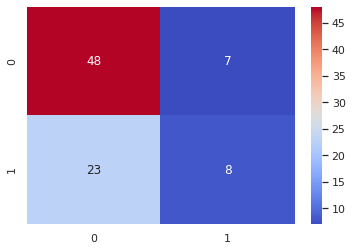

In [ ]:
#pretty display

import seaborn as sn
sn.heatmap(cm, annot=True, cmap='coolwarm')

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(yTest, yPred)
print("Accuracy : "+str(round(acc, 4)*100)+"%")

Accuracy : 65.12%


In [ ]:
#we can display the importance of input features in the decision process
importance_by_features = clf.feature_importances_

pd.DataFrame([importance_by_features_percentage], columns=x.columns)

,age,tumor-size,inv-nodes,is-node-caps,deg-malig,isLeftBreast,isIrradiat,isPremeno,isGe40,isLt40,left_low,right_up,left_up,right_low,central
0,11.31%,22.46%,12.59%,8.23%,13.36%,5.01%,5.08%,2.26%,2.74%,1.6%,3.04%,4.0%,4.21%,2.21%,1.9%
